In [93]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
from pandas_summary import DataFrameSummary
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.svm import SVC
from IPython.core.debugger import set_trace
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
%matplotlib inline
from IPython.core.debugger import set_trace #!!TODO: remove this

In [4]:
from dateutil.parser import parse
train_set_df = pd.read_csv("train_set.csv", parse_dates = ['timestamp'], date_parser = parse )
test_set_df = pd.read_csv("test_set.csv", parse_dates = ['timestamp'], date_parser = parse )

In [5]:
y_train_raw = train_set_df.label
train_set_grouped_by_patients = train_set_df.groupby('patient_id')



# EDA

**Initial examination of the raw data**

In [ ]:
train_set_df.describe()

In [ ]:
dfs = DataFrameSummary(train_set_df)

In [ ]:
pp.ProfileReport(train_set_df)

**The distribution of labels over the raw data is approx: 68% - class 0, 20% - class 1, and 12% - class 2**

In [ ]:
tmp = plt.hist(y_train_raw, bins =  [0,1,2,3] )

In [ ]:
tmp

In [ ]:
tmp[0]/sum(tmp[0])

**The labels are attributes of patients, not of specific samples (all patient's samples have the same label )** 

In [ ]:
inds_0 = y_train_raw==0
inds_1 = y_train_raw==1
inds_2 = y_train_raw==2

In [ ]:
patiends_0_set = set(train_set_df[inds_0]['patient_id'])
patiends_1_set = set(train_set_df[inds_1]['patient_id'])
patiends_2_set = set(train_set_df[inds_2]['patient_id'])

In [ ]:
patiends_0_set.intersection(patiends_1_set)

In [ ]:
patiends_0_set.intersection(patiends_2_set)

In [ ]:
patiends_1_set.intersection(patiends_2_set)

**Each patient's data consists of 3 time series. The number of samples in these series across the patients varies between 1 (single sample) and nearly 100**

In [ ]:
train_set_samples_sizes = [len(pdf[1]) for pdf in train_set_grouped_by_patients]
plt.hist(train_set_samples_sizes, bins = np.arange(0,100));
plt.title("Train set - #samples per patient");
plt.xlabel("#samples");
plt.ylabel("#patients");

**The test set has similar distribution, which means, in particular, that we'll need to predict labels of series consisting of a single time sample**

In [ ]:
test_set_samples_sizes = [len(pdf[1]) for pdf in test_set_df.groupby('patient_id')]
plt.hist(test_set_samples_sizes, bins = np.arange(0,100));
plt.title("Test set - #samples per patient");
plt.xlabel("#samples");
plt.ylabel("#patients");

**Since the timedelta between each sample is 50ms, the corresponding series durations vary between 0 sec (single sample) to nearly 5 sec (100 samples)** 

In [ ]:
train_set_samples_durations = [(pdf[1]['timestamp'].iloc[-1] - pdf[1]['timestamp'].iloc[0]).total_seconds() for pdf in train_set_grouped_by_patients]
plt.hist(train_set_samples_durations, density=True, bins = np.arange(0, 5, 0.1));
plt.title("Patients timeseries duration (seconds) ");
plt.xlabel("series duration");
plt.ylabel("density");

**Some series are inconsistent in terms of their sizes and durations. Below we see some series with 5 samples (corresponding to 0.2 sec), whose duration is less than 0.2 sec** 

In [ ]:
np.array(train_set_samples_durations)[np.array(train_set_samples_sizes)==5]

**Let's find the one with duration 0**

In [ ]:
np.argmax((np.array(train_set_samples_sizes)==5) & (np.array(train_set_samples_durations) < 0.05))

In [ ]:
train_set_grouped_by_patients.get_group(18186)

**Seems that the samples behave properly (they are not constant), so it seems like a bug in the timestamps registration. We can either remove such samples as outliers or fix their timestamps based on their number of samples**

**Here's another example:**

In [ ]:
train_set_grouped_by_patients.get_group(np.argmax((np.array(train_set_samples_sizes)==5) & (np.array(train_set_samples_durations) == 0.1)))

In [ ]:
all_inconsistent_indices


## TimeSeries - acquaintance 

Since the class is a property of the patient, let's examine the per-patient classes. The classes proportions remain the same as when counting the raw samples. 

In [ ]:
patients_classes_df = train_set_grouped_by_patients.nth(0)['label']
print(f"there are {len(patients_classes_df)} patients altogether")
patients_classes_df.hist(bins=[0,1,2,3], density=True);
y_per_patient = patients_classes_df.values

In [ ]:
#Plot a patient timeseries, optionally with the regressed approximations superimposed (this comes later on)
def plot_patient_lines(patient_id, extracted_features = None, plot_ax = None):
    if plot_ax is None:
        fig_p, ax_p = plt.subplots()
    else:
        ax_p = plot_ax
    
    curr_patient_df = train_set_grouped_by_patients.get_group(patient_id)
    first_timestamp = curr_patient_df['timestamp'].iloc[0]
    curr_patient_df.index = list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, curr_patient_df['timestamp']))
    curr_patient_df[['measurement_x', 'measurement_y', 'measurement_z']].plot(ax=ax_p)
    if extracted_features is not None:
        coefs = extracted_features.reshape(3,3).T
        x_regr = curr_patient_df.index.values
        x_mat = np.array([np.ones(len(x_regr)), x_regr, x_regr*x_regr ]).T
        curr_patient_df_approx = pd.DataFrame( x_mat.dot(coefs), 
                                              columns = ['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr'], 
                                                index = curr_patient_df.index
                                             )
        curr_patient_df_approx[['measurement_x_regr', 'measurement_y_regr', 'measurement_z_regr']].plot(ax=ax_p, style='--')
    ax_p.set_title(f"Patient {patient_id} timeseries")
    ax_p.set_xlabel("time from first timestamp (ms)")
    return len(curr_patient_df), ax_p

#Choose n_patient random patients of class patient_class
def choose_rand_patients( n_patients, patient_class ):
    if patient_class not in [0,1,2]:
        raise Exception("Specified patient_class is not in existing classes set: [0,1,2]")
    patient_class_inds = y_per_patient==patient_class
    num_class_patients = sum(patient_class_inds)
    if n_patients > num_class_patients:
        raise Exception("Specified num samples {} exceeds the number of patients of requested class {}".format(n_patients, patient_class))
    selected_class_inds = random.sample(range(0, num_class_patients), n_patients)
    selected_patients = patients_classes_df[patient_class_inds].index[selected_class_inds]
    return selected_patients.values



**Let's view some timeseries of each of the classes**

In [ ]:
patients_ids = choose_rand_patients(1,1)

plot_patient_lines(patients_ids[0])

**Typical and less typical classes timeseries**

Based on sproradic visual inspection of the timelines. Left images are the more typical, right ones seems less typical to each class.  

In [ ]:
curr_figsize = plt.rcParams['figure.figsize'] 
plt.rcParams['figure.figsize'] = [12, 3]
fig_0, (ax_0_typical, ax_0_non_typical) = plt.subplots(1,2)
plot_patient_lines(20072, plot_ax=ax_0_typical)
plot_patient_lines(15179, plot_ax=ax_0_non_typical)
fig_0.suptitle("Class 0 timeline - typical and less typical \n")
plt.tight_layout()

fig_1, (ax_1_typical, ax_1_non_typical) = plt.subplots(1,2)
plot_patient_lines(9400, plot_ax=ax_1_typical)
plot_patient_lines(13166, plot_ax=ax_1_non_typical)
fig_1.suptitle("Class 1 timeline - typical and less typical \n")
plt.tight_layout()


fig_2, (ax_2_typical, ax_2_non_typical) = plt.subplots(1,2)
fig_2.suptitle("Class 2 timeline - typical and less typical \n")
plot_patient_lines(8345, plot_ax=ax_2_typical)
plot_patient_lines(3520, plot_ax=ax_2_non_typical) 
plt.tight_layout()
plt.rcParams['figure.figsize']  = curr_figsize 

In [ ]:
 curr_figsize 

**Intermediate summary**

- Each patient is characterized by his/her 3 timeseries.  
- Visual inspection indicates that each class has a typical footprint in terms of its signals and their mutual configuration.
- A reasonable direction would be to represent each signal as a 1st or 2nd order polynomial, and use the coefficient as the features set for each patient.
- We can possibly add more features - e.g. whether or not signals intersect (typical to class 2), the average distance between signals (typically the y and z signals in class 1 are close)

# Features engineering

In [6]:
#Possible additional schemes: whether or not the x and y signals interserct. 
extraction_schemes = ['parabola']

def extract_signals_params(signals_df, extraction_scheme):
   
    timestamps = signals_df.loc[:, 'timestamp']
   
    first_timestamp =  timestamps.iloc[0]
    x = np.array(list(map(lambda ts : (ts -first_timestamp).total_seconds()*1000, timestamps)))
    x = np.array([x, x*x]).T #When the extraction_schemt is 'parabole', actually.
    sigs =  signals_df.loc[:, ['measurement_x', 'measurement_y', 'measurement_z']].values
    #Regress each signal to a 2nd order polynomial
    reg = LinearRegression().fit(x, sigs )
    #Add the initial value of each signal, and flatten to a single list.
    #Explicitly adding the intial value is redundant, since x starts at 0, hence the intercept is just this initial value
    return list(np.concatenate((np.array([reg.intercept_]).T, reg.coef_), axis=1).reshape(1,-1)[0])
    
    
def extract_single_patient_features( patient_df, extraction_scheme ):
    patient_id = patient_df['patient_id'].iloc[0]
    patient_features = []
    curr_line_params = extract_signals_params(patient_df, extraction_scheme)
    patient_features += curr_line_params
    return patient_features
        
    
def extract_features(in_df, extraction_scheme='parabola'):
    #TODO: input sanity checks
    X = []
    y = []
    for _,patient_df in in_df.groupby('patient_id'):
        extracted_features = extract_single_patient_features( patient_df, extraction_scheme )
        X.append(extracted_features )
        if 'label' in patient_df:
            y.append(patient_df['label'].iloc[0])
    features_names = ['meas_{}_a{}'.format(i,j) for i in ['x', 'y', 'z'] for j in range(3)]
    return np.array(X), np.array(y), features_names





In [7]:
X, y features_names = extract_features(train_set_df)


**Let's check how well this model encodes the timeseries**

In [ ]:
plot_patient_lines(8345, X[8345,:]);

Plot $X|y$, just to get a feeling of how well the features are seperable.

In [ ]:
x_0 = X[ y==0, :]
x_1 = X[ y==1, :]
x_2 = X[ y==2, :]
# len(x_0)
fig_x_given_y, ax_x_given_y = plt.subplots()
bins_f8 = np.arange(-0.0000001, 0.00000001, 0.000000001)
bins_f0 = np.arange(0, 1.5, 0.01)
bins_f2 = np.arange(-0.00000004, 0.00000004, 0.000000001)
bins_f3 = np.arange(-0.2, 0.6, 0.01)
ax_x_given_y.hist(x_0[:,0], bins=bins_f0);
ax_x_given_y.hist(x_1[:,0], bins=bins_f0);
ax_x_given_y.hist(x_2[:,0], bins=bins_f0);



**3d visualization (3 same order coefficients of the timeseries) indicate that classes 0, 1 are more seperable than class 2.** 

In [ ]:
import plotly.express as px
i=2
j=5
k=8

def plot_3d_features(i, j, k, title):
    fig = go.Figure(data=[go.Scatter3d(x= x_0[:,i], y=x_0[:,j], z=x_0[:,k],
                                       mode='markers', name='class 0', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    ))])
    fig.add_trace( go.Scatter3d(x= x_1[:,i], y=x_1[:,j], z=x_1[:,k],
                                       mode='markers', name='class 1', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    )))

    fig.add_trace( go.Scatter3d(x= x_2[:,i], y=x_2[:,j], z=x_2[:,k],
                                       mode='markers', name='class 2', 
                                       marker=dict(
                                        size=2,
                                        opacity=0.6
                                    )))
    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    fig.show()

plot_3d_features(0, 3, 6,  "3 classes ts 0nd order coefficient")
plot_3d_features(2, 5, 8,  "3 classes ts 2nd order coefficient")



# Classification

In [97]:
X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(X, y, np.arange(len(y)), test_size = 0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [98]:
#Verify the classes proportions remain.
print("Classes proportions in train set: 0:{}, 1:{}, 2:{}".format((y_train == 0).sum()/len(y_train), 
                                                                  (y_train == 1).sum()/len(y_train), 
                                                                  (y_train == 2).sum()/len(y_train)))


Classes proportions in train set: 0:0.6857615249951371, 1:0.24202489787978992, 2:0.07221357712507294


**Find optimal meta parameters**

In [99]:
class ClassifierContainer:
    
    def __init__(self, clf, long_params_list, short_params_list):
        self.clf = clf
        self.long_params_list = long_params_list
        self.short_params_list = short_params_list
        
    
classifiers_dict = {
    'svm': ClassifierContainer(SVC(),
                    [{'kernel': ['rbf'], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
                     'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 700, 800, 1000, 1200, 1500]},
                    {'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}
                    ], 
                    [{'kernel': ['rbf'], 'gamma': [  1],
                     'C': [300, 500, 1000, 1500]}
                    ]
            ), 
                            
    'random_forest' : ClassifierContainer(RandomForestClassifier(), 
                           [{ 'n_estimators' : [100, 200, 500, 1000, 1200, 1500],
                              'max_depth': [ 10, 20, 30, 40, 50, 60, 100], 
                              'class_weight' :['balanced'] }
                           ], 
                            [{ 'n_estimators' : [ 1000],
                              'max_depth': [ 30], 
                              'class_weight' :['balanced'] }
                           ]
                    ),
    
    'xgboost' : ClassifierContainer( xgb.XGBClassifier(), 
                           [{ 'reg_lambda' : [0.1, 0.3, 1, 3, 10, 30, 100, 300],
                             'gamma' : [0.001, 0.003, 0.1, 0.3, 1, 3, 10, 30, 100, 300],
                              'max_depth': [ 10, 20, 30, 40, 50, 60, 100], 
                               }
                           ], 
                             [{ 'reg_lambda' : [ 1],
                             'gamma' : [ 100],
                              'max_depth': [ 30], 
                               }
                           ]
                    )
            
}

In [100]:
def find_optimal_meta_parameters(train_x, train_y, classifier, tuned_parameters_dict, score='f1'):
    
    scores = [score]
    #This one takes quite some time to complete...
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
           classifier, tuned_parameters_dict, scoring='%s_macro' % score
        )
        clf.fit(train_x, train_y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    return clf.best_estimator_


In [ ]:
tune_long_list = True
tuned_classifiers = {}
for clfname in c lassifiers_dict:
    print( "\n ############## Tuning meta parameters for classifier {} ########### \n".format(clfname))
    clf_params_to_tune = classifiers_dict[clfname]
    curr_best_estimator = find_optimal_meta_parameters(X_train_scaled, y_train, clf_params_to_tune.clf, 
                                 clf_params_to_tune.long_params_list if tune_long_list else clf_params_to_tune.short_params_list,
                                 score='f1')
    tuned_classifiers[clfname] = curr_best_estimator





 ############## Tuning meta parameters for classifier svm ########### 

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 700, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.543 (+/-0.007) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.642 (+/-0.016) for {'C': 0.01, 'gamma': 0.03, 'kernel': 'rbf'}
0.680 (+/-0.019) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.575 (+/-0.002) for {'C': 0.01, 'gamma': 0.3, 'kernel': 'rbf'}
0.541 (+/-0.012) for {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.271 (+/-0.000) for {'C': 0.01, 'gamma': 3, 'kernel': 'rbf'}
0.271 (+/-0.000) for {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}
0.271 (+/-0.000) for {'C': 0.01, 'gamma': 30, 'kernel': 'rbf'}
0.737 (+/-0.023) for {'C': 0.03, 'gamma': 0.01, 'kernel': 'rbf'}
0.808 (+/-0.020) for {'C': 0.03, 'gamma': 0.03, 'kernel': 'rbf'}
0.830 (+/-0.016) for {'C': 0.03, 'gamma': 0.1, 'kernel': 'rbf'}
0.799 (+/-0.011) for {'C': 0.03, 'gamma': 0.3, 'kernel': 'rbf'}
0.583 

In [91]:
def plot_features_importances(importances):
    plt.figure(figsize=(12, 3))
    plt.title("Feature importances")
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[indices],
            color="r",align="center")
    plt.xticks(range(len(importances)), np.array(features_names)[indices])
    plt.xlim([-1, len(importances)])
    plt.show()



################# cassification report for classifier svm ################

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3511
           1       1.00      1.00      1.00      1237
           2       1.00      1.00      1.00       394

    accuracy                           1.00      5142
   macro avg       1.00      1.00      1.00      5142
weighted avg       1.00      1.00      1.00      5142


 Confusion matrix (Wikipedia format):

[[3511    0    0]
 [   0 1237    0]
 [   0    0  394]]

 Confusion matrix (sklearn (transposed) format):



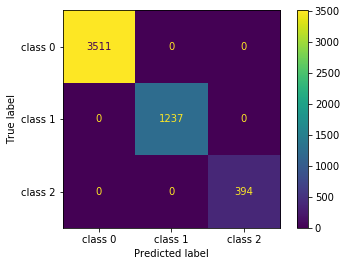

Can't produce feature importance for classifier svm

##################################################################################



################# cassification report for classifier random_forest ################

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3511
           1       1.00      1.00      1.00      1237
           2       1.00      1.00      1.00       394

    accuracy                           1.00      5142
   macro avg       1.00      1.00      1.00      5142
weighted avg       1.00      1.00      1.00      5142


 Confusion matrix (Wikipedia format):

[[3507    4    0]
 [   4 1233    0]
 [   0    0  394]]

 Confusion matrix (sklearn (transposed) format):



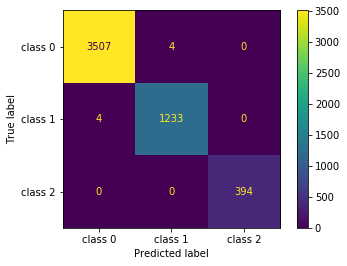

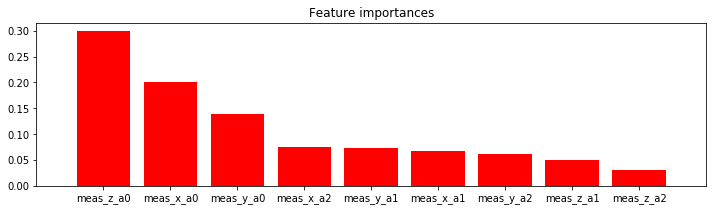


##################################################################################



################# cassification report for classifier xgboost ################

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3511
           1       0.99      0.99      0.99      1237
           2       0.99      1.00      1.00       394

    accuracy                           1.00      5142
   macro avg       0.99      1.00      0.99      5142
weighted avg       1.00      1.00      1.00      5142


 Confusion matrix (Wikipedia format):

[[3502   10    0]
 [   9 1225    1]
 [   0    2  393]]

 Confusion matrix (sklearn (transposed) format):



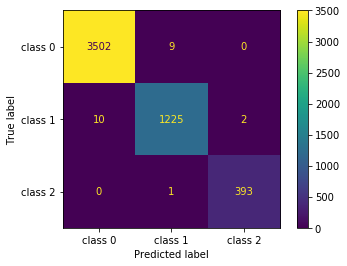

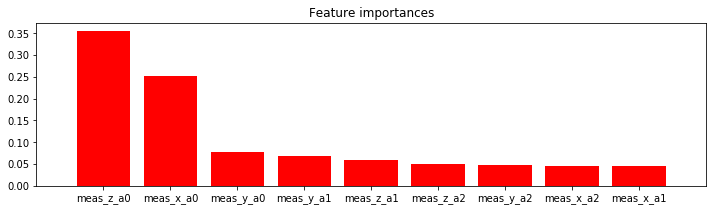


##################################################################################

The classifier with the maximal minimal f1 score is svm


In [101]:
#Summarize the performance of each of the tuned classifiers, and find the one with max-min F1 score.
from sklearn.metrics import plot_confusion_matrix
min_f1 = {}
curr_figsize = plt.rcParams['figure.figsize']
for clfname in tuned_classifiers:
    print()
    print( "\n################# cassification report for classifier {} ################\n".format(clfname))
    clf = best_classifiers[clfname]
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print( classification_report(y_true, y_pred) )
    print("\n Confusion matrix (Wikipedia format):\n")
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T) 
    print("\n Confusion matrix (sklearn (transposed) format):\n")
    plot_confusion_matrix(clf, X_test_scaled, y_true, display_labels=['class 0', 'class 1', 'class 2'], values_format='.0f')
    plt.show()
    if hasattr(clf, 'feature_importances_'):
        plot_features_importances( clf.feature_importances_)
    else:
        print("Can't produce feature importance for classifier {}".format(clfname))
        
    min_f1[clfname] = np.min(f1_score(y_true, y_pred, average=None))
    print("\n##################################################################################\n")
    
sorted_clfnames_by_scores = [k for k, v in sorted(min_f1.items(), key=lambda item: item[1])]
best_classifier = tuned_classifiers[sorted_clfnames_by_scores[-1]]
print("The classifier with the maximal minimal f1 score is {}".format(sorted_clfnames_by_scores[-1]))

In [96]:
min_f1

{'svm': 1.0,
 'random_forest': 0.9987859166329423,
 'xgboost': 0.9983818770226538}

# Submission


**Use the entire training set to train the submission classifier**

In [74]:
X_test_for_submission,_  = extract_features(test_set_df)
scaler_submission = preprocessing.StandardScaler().fit(X)
X_scaled = scaler_submission.transform(X)
X_test_for_submission_scaled = scaler_submission.transform(X_test_for_submission)

In [ ]:
tune_long_list = True
tuned_classifiers_submission = {}
for clfname in classifiers_dict:
    print( "\n ############## Tuning meta parameters for classifier {} \n".format(clfname))
    clf_params_to_tune = classifiers_dict[clfname]
    curr_best_estimator = find_optimal_meta_parameters(X_scaled, y, clf_params_to_tune.clf, 
                                 clf_params_to_tune.long_params_list if tune_long_list else clf_params_to_tune.short_params_list,
                                 score='f1')
    tuned_classifiers[clfname] = curr_best_estimator


In [ ]:
# Now apply on provided test set.
y_test_hat = clf.predict(X_test_scaled)
res_df = pd.DataFrame( { 'label' : y_test_hat, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
res_df.to_csv("clew_assignment_submission_matan.csv")

In [82]:
tmp = sklearn.metrics.f1_score(y_true, y_pred, average=None)


In [83]:
tmp


array([0.99415371, 0.97972425, 0.98881988])

In [ ]:


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
                     'C': [1, 30, 100 ,300, 500, 800, 1000, 1500]}
                   ]
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(
       SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_scaled, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    
# Now apply on provided test set.
y_test_hat = clf.predict(X_test_scaled)
res_df = pd.DataFrame( { 'label' : y_test_hat, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
res_df.to_csv("clew_assignment_submission_matan.csv")

**SVM with gaussian kernel**

In [ ]:
#################### SVM ####################
from sklearn.svm import SVC
from IPython.core.debugger import set_trace
# SVM with gaussian kernel


from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
                     'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 700, 800, 1000, 1500]},
                    {'kernel': ['linear'], 'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}]



scores = ['f1']
#This one takes quite some time to complete...
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
#################### SVM ####################
from sklearn.svm import SVC
from IPython.core.debugger import set_trace
# SVM with gaussian kernel


from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [  1],
                     'C': [300, 500, 800, 1000, 1500]}
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()
    

**Where have we missed?**

In [ ]:
[ i for i,val in enumerate((y_true == 2) & (y_pred == 1)) if val]

In [ ]:
inds_test[1194]

In [ ]:
X_test[240,:]
plot_patient_lines(24602, X[24602,:] )

**Random Forest**

In [ ]:
tuned_parameters = [{  
                       'n_estimators' : [100, 200, 500, 1000],
                        'max_depth': [ 10, 20, 30, 40, 50, 60], 
                       'class_weight' :['balanced']
                    }
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       RandomForestClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()

In [ ]:
tuned_parameters = [{ 'reg_lambda' : [0.1, 0.3, 1, 3, 10, 30, 100, 300],
                             'reg_alpha ' : [0.1, 0.3, 1, 3, 10, 30, 100, 300],
                              'max_depth': [ 10, 20, 30, 40, 50, 60], 
                               }
                           ]


scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       xgb.XGBClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()

In [ ]:
def plot_roc()
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
############################## Logistic Regression ########################

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_logit = scaler.transform(X_train)
# X_logit_test = scaler.transform(X_test)
clf = LogisticRegressionCV(cv=5, max_iter = 1000).fit(X_train_scaled, y_train)
y_hat = clf.predict(X_test_scaled)
# X_test_predicted_0 = X_test[y_hat==0]
# X_test_predicted_1 = X_test[y_hat==1]
# plt.scatter(X_test_predicted_0[:,0], X_test_predicted_0[:,1], c='y')
# plt.scatter(X_test_predicted_1[:,0], X_test_predicted_1[:,1], c='b')

cnf_matrix = confusion_matrix(y_test, y_hat, labels=[0, 1, 2])
print(cnf_matrix.T)
print(classification_report(y_test, y_hat))

## More classifiers

In [ ]:
# algorithms 
clf_dict = {"Logistic Regression":LogisticRegression(penalty='l2', C=1, class_weight='balanced', solver='lbfgs'), # 
            "Random Forest": RandomForestClassifier(n_estimators=55, random_state=6),
            "XGBoost": xgb.XGBClassifier()#(objective='multi:softmax')#, num_class=num_class
           }


classifiers = {
#     "LogisiticRegression": LogisticRegression(),
#     "KNearest": KNeighborsClassifier(),
#     "Support Vector Classifier": SVC(),
#     "DecisionTreeClassifier": DecisionTreeClassifier()
# }

tuned_parameters = [{  'n_neighbors': [2, 3, 4]}
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       KNeighborsClassifier(), tuned_parameters, scoring='%s_macro' % score, cv=7
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()

In [ ]:
# classifiers = {
#     "LogisiticRegression": LogisticRegression(),
#     "KNearest": KNeighborsClassifier(),
#     "Support Vector Classifier": SVC(),
#     "DecisionTreeClassifier": DecisionTreeClassifier()
# }

tuned_parameters = [{  'Cs': [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]], 
                        'class_weight' : [None, 'balanced']
                    }
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       LogisticRegression(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()

In [ ]:
tuned_parameters = [{  'max_depth': [ 10, 20, 30, 40, 50, 60], 
                       'class_weight' :['balanced']
                    }
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       DecisionTreeClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train_scaled, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_scaled)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
    print()

In [ ]:
tuned_parameters = [{  'max_depth': [ 4,5, 6, 10, 20, 30, 40, 50, 60], 
                       'class_weight' :['balanced']
                    }
                    ]



scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
       DecisionTreeClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_scaled, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
#     y_true, y_pred = y_test, clf.predict(X_test_scaled)
#     print(classification_report(y_true, y_pred))
#     print(confusion_matrix(y_true, y_pred, labels=[0,1,2]).T)
#     print()

# clf.fit(, y)

In [ ]:
dfcv = pd.DataFrame(clf.cv_results_)
dfcv

In [ ]:
dfcv[["split{}_test_score".format(j) for j in range(7)]].mean(axis=1)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
# print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
# print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()






# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train, test in sss.split(X_train_scaled, y_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(X_train_scaled[train], y_train[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(X_train_scaled[test])
    
    accuracy_lst.append(pipeline.score(X_train_scaled[test], y_train[test]))
    precision_lst.append(precision_score(y_train[test], prediction))
    recall_lst.append(recall_score(y_train[test], prediction))
    f1_lst.append(f1_score(y_train[test], prediction))
    auc_lst.append(roc_auc_score(y_train[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.03, 0.1],
                     'C': [ 800, 1000]}
                   ]
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(
       SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_scaled, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    
# Now apply on provided test set.
y_test_hat = clf.predict(X_test_scaled)
res_df = pd.DataFrame( { 'label' : y_test_hat, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
res_df.to_csv("clew_assignment_submission_matan.csv")

In [ ]:
y_hat_test_of_submission_clf = clf.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_hat_test_of_submission_clf))

In [ ]:
clf_svc_partial_train = SVC(C=1000, kernel='rbf', gamma=1)
clf_svc_full_train = SVC(C=1000, kernel='rbf', gamma=0.03)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
# X_test_raw_scaled = scaler.transform(X_t)

In [ ]:
clf_svc_partial_train.fit(X_train_scaled, y_train)
y_hat_partial = clf_svc_partial_train.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test, y_hat_partial))

In [ ]:
clf_svc_full_train.fit(X_scaled, y)
y_hat_full = clf_svc_full_train.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test, y_hat_full))

In [ ]:
test_set_df.groupby('patient_id').nth(0).index

In [ ]:
res_df = pd.DataFrame( { 'label' : y_test_hat, 'patient_id' : test_set_df.groupby('patient_id').nth(0).index.values})
res_df.to_csv("clew_assignment_submission_matan.csv")

In [ ]:
np.unique(y_pred)

In [ ]:
y_true_binary = y_true
y_true_binary[y_true_binary == 1] = 0
y_true_binary[y_true_binary == 2] = 1
np.unique(y_true_binary)
print(np.unique(y_true))
y_pred_binary = y_pred
y_pred_binary[y_pred_binary == 1] = 0
y_pred_binary[y_pred_binary == 2] = 1
np.unique(y_pred_binary)
all((y_pred_binary==1) == (y_pred == 2))
# sklearn.metrics.f1_score(y_true_binary, y_pred_binary) 
print(classification_report(y_true_binary, y_pred_binary))
print(confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1]).T)
print(confusion_matrix(y_true, y_pred, labels=[0, 1,2]).T)

In [ ]:
np.unique(y_true)

TODO:
* Remove outliers (corrupted ts)
* Weigh signals based on their duration (a signal of 4 timestamps is less indicative than a 30 samples one). Additionally - apply classification on only the subset of signals with more than M timestamp and show scores over this set. 
* More features: do lines intersect? what's the average distane between two lines?
* Beautify code: add parameters types, sanity tests and comments, remove debug printouts.

* Add ROC
* If possible - use these fancy auto analysis pandas tools.

Theoretical:
* squared v.s. abs regularization
* Trees v.s. LR v.s. SVM - which one will be better under which circumstances? 

Interesting examples:
* 15175, 15176 - two examples of 2 class which are quite different
* 15178, 15179 - two examples of 0 class which seem identical, and also typical to type 2 class. More typical 0 ones: 1903


In [ ]:
plt.rcParams['figure.figsize']

In [ ]:
y_true_fab = [ 0,0,0,0,0,0,0,0, 1,1,1, 1, 2, 2, 2]
y_hat_fab = [ 0,0,0,0,0,0,1,2, 1,1,0, 2, 1, 2, 2]
print(classification_report(y_true_fab, y_hat_fab, labels=[0,1,2]))
print(confusion_matrix(y_true_fab, y_hat_fab).T)

In [ ]:
6/7